# Regressão Logística & Métricas de Classificação

## Interpretabilidade em Modelos de Machine Learning

Neste notebook, veremos como utilizar ferramentas que nos auxiliam a interpretar cada predição do modelo, bem como entender suas características como um todo.

In [1]:
# descomentar a linha seguinte p/ adicionar o pacote SHAP no conda env
#!conda install -c conda-forge shap=0.27.0 -y

In [2]:
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import shap

/Users/gabrielcs/anaconda/envs/tera-out2019/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gabrielcs/anaconda/envs/tera-out2019/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Appl

In [3]:
shap.initjs()

#### Carregando os dados

In [4]:
df = pd.read_csv('../data/bank_marketing_processed.csv')
df_display = pd.read_csv('../data/bank_marketing_display.csv')

In [5]:
X = df.drop(columns=['subscribed'])
X_display = df_display.drop(columns=['subscribed'])
y = df['subscribed']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

X_train_display, X_test_display, _, _ = train_test_split(X_display, y, test_size=0.2, 
                                                         random_state=0)

#### Carregando o modelo

In [7]:
logreg = joblib.load('../models/logreg.pkl')

## Interpretação do modelo

Para interpretar o modelo treinado e as suas predições, nós utilizaremos o SHAP. Para mais detalhes sobre o seu funcionamento, recomendamos como referência a sua [página no GitHub](https://github.com/slundberg/shap).

In [8]:
linear_explainer = shap.LinearExplainer(logreg, data=X_train, feature_dependence='independent')
shap_values = linear_explainer.shap_values(X_train)

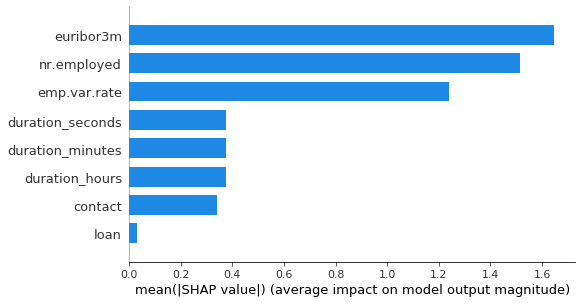

In [9]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

No gráfico acima, é possível verificar as features de maior e de menor importância para o modelo.

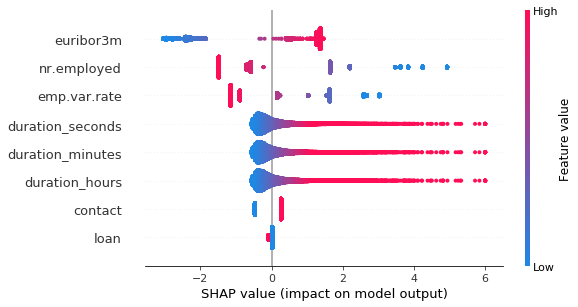

In [10]:
shap.summary_plot(shap_values, X_train, plot_type='dot')

Podemos ver acima que as features de duração têm comportamento idêntico no modelo. Inclusive, em modelos lineares, é recomendado que se remova as features colineares, mantendo apenas uma delas.

No mais, vemos que quanto maior a duração, maiores são as probabilidades de conversão. Já as features `nr.employed` e `emp.var.rate` têm comportamento contrário - quando são valores são baixos, elas tendem a ter impacto posivito nas probabilidades.

## Intepretação de predições individuais

*Os plots abaixo podem não ser exibidos no GitHub ou em versões antigas do Jupyter.*

In [11]:
print(f'Base value (before logistic transformation): {linear_explainer.expected_value:.4f}')

Base value (before logistic transformation): -1.3480


In [12]:
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

In [13]:
print(f'Base value (after logistic transformation): {logistic_function(linear_explainer.expected_value):.4f}')

Base value (after logistic transformation): 0.2062


#### Cliente índice `0`

In [14]:
cliente_id = 0

In [15]:
shap.force_plot(linear_explainer.expected_value,
                shap_values[cliente_id,:], 
                X_train_display.iloc[cliente_id,:],
                link='logit')

É possível ver acima que o cliente de ID `0` tem apenas 0.6% de probabilidade de conversão. Os motivos principais para essa probabilidade baixa são os valores das variáveis `nr.employed` e `emp.var.rate`. Um dos motivos que aumentam um pouco sua probabilidade é o valor do `euribor3m`.

#### Cliente índice `7`

In [16]:
cliente_id = 7

shap.force_plot(linear_explainer.expected_value, 
                shap_values[cliente_id,:], 
                X_train_display.iloc[cliente_id,:],
                link='logit')

Já o cliente de ID `7` tem uma probabilidade de conversão alta, de 97%. Os motivos principais são as variáveis de duração da ligação.

No caso do banco português, uma boa análise poderia ser entender as predições do cliente com maior probabilidade que não converteu e do cliente com menor probabilidade que converteu. Isso pode 1) trazer insights sobre como melhorar o modelo e/ou 2) trazer mais confiança de que o modelo está fazendo as coisas certas.

### Análise feature a feature

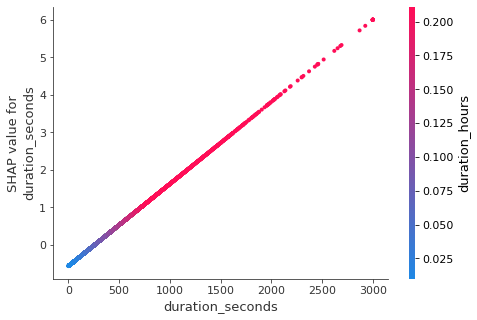

In [17]:
shap.dependence_plot('duration_seconds', shap_values, X_train_display)

No plot acima, é possível ver que o modelo aprendeu que valores de `duration_seconds` abaixo de `~240` (4 minutos) reduzem as probabilidades, enquanto valores acima disso elevam as probabilidades.